In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 10.1 MB/s eta 0:00:00


In [2]:
import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing the Data

In [4]:
# Loading the path to the folder
DATA_PATH = "/content/drive/MyDrive/studia/Inżynierka/MAIN/"

In [11]:
del data

In [12]:
# Loading the prepared dataset
data = pd.read_csv(DATA_PATH + 'PreparedDataset.csv', low_memory=False)
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
print(data.info())
ticker = 'DXC'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481 entries, 0 to 3480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  3481 non-null   datetime64[ns, UTC]
 1   Close     3481 non-null   float64            
 2   Returns   3481 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 81.7 KB
None


In [13]:
ticker

'DXC'

In [14]:
data

,Datetime,Close,Returns
0,2022-12-12 17:30:00+00:00,26.840000,0.22
1,2022-12-12 18:30:00+00:00,26.965000,0.47
2,2022-12-12 19:30:00+00:00,27.200001,0.87
3,2022-12-12 20:30:00+00:00,27.299999,0.37
4,2022-12-13 14:30:00+00:00,27.719999,1.54
...,...,...,...
3476,2024-12-06 16:30:00+00:00,22.120001,-0.76
3477,2024-12-06 17:30:00+00:00,22.070000,-0.23
3478,2024-12-06 18:30:00+00:00,22.020000,-0.23
3479,2024-12-06 19:30:00+00:00,22.070000,0.23


## Checking the Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("Results of Dicky-Fuller Test:")
dftest = adfuller(data['Close'], autolag='AIC')

output = pd.Series(dftest[0:4], index=['ADF Statistic:','p-value:','Lags:','Number of Observations:'])
for key,value in dftest[4].items():
    output['Critical Value (%s):'%key] = value

print(output)

Results of Dicky-Fuller Test:
ADF Statistic:               -1.043379
p-value:                      0.737116
Lags:                         7.000000
Number of Observations:    3482.000000
Critical Value (1%):         -3.432229
Critical Value (5%):         -2.862370
Critical Value (10%):        -2.567212
dtype: float64


p-value is greater than significance level of 0.05, then we fail to reject the hypothesis- close price data is non-stationary.

In [ ]:
# Definig the stationarity
data.loc[:,'Close'] = data['Close'].diff(periods=1).dropna()


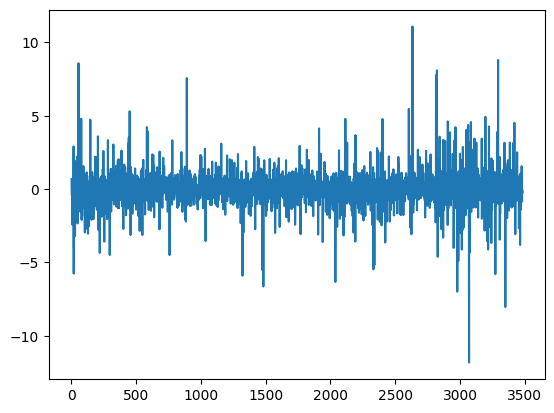

In [ ]:
plt.plot(data['Close'])

## Defining the variables

In [15]:
prices = data[['Datetime', 'Close']]
prices = prices.set_index('Datetime')
returns = data['Returns']

## Splitting the data

In [16]:
train_size = int(len(returns) * 0.7)
train_returns = returns[:train_size]
test_returns = returns[train_size:]

## GARCH VOLATILITY MODEL

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3376.04
Distribution:                  Normal   AIC:                           6760.09
Method:            Maximum Likelihood   BIC:                           6783.28
                                        No. Observations:                 2436
Date:                Fri, Dec 13 2024   Df Residuals:                     2435
Time:                        17:58:09   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0318  6.240e-02      0.509      0.611 [-9.05

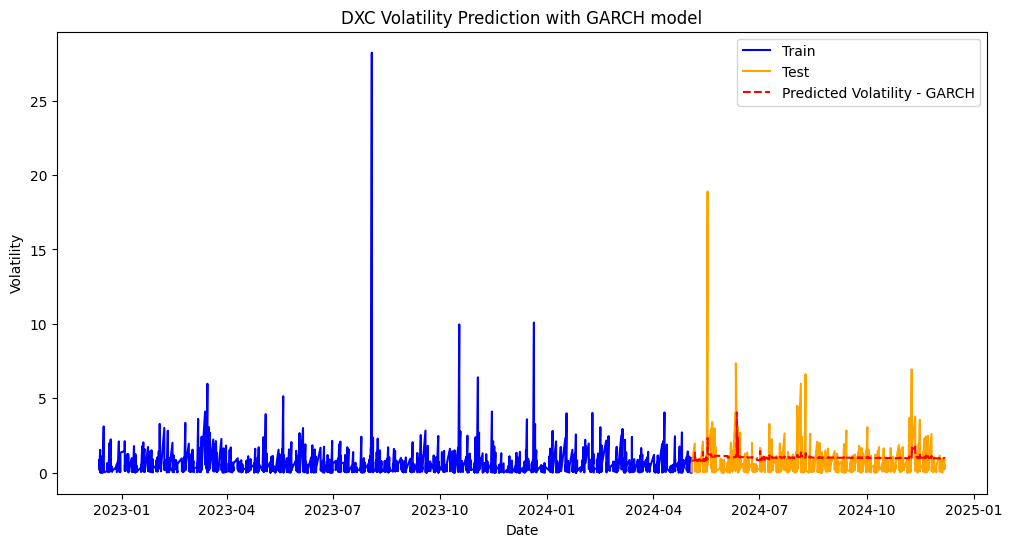

Mean Squared Error: 2.21
Root Mean Squared Error: 1.49
Mean Absolute Percentage Error: inf
Mean Absolute Error: 1.13


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit GARCH MODEL order (1, 1) on the training data
model = arch_model(train_returns, vol='GARCH', p=1, q=1)

# Defining iteration limit to 10,000
options = {'maxiter': 10000}

# Fitting GARCH MODEL
model_fit = model.fit(disp='off', options=options)

# GARCH MODEL summary
print(model_fit.summary())

# Rolling forecast for test data
history = train_returns.tolist()
predicted_volatility = []

for t in range(len(test_returns)):
    # Fit GARCH MODEL on the rolling window (using historical data)
    model = arch_model(history, vol='GARCH', p=1, q=1)

    try:
        model_fit = model.fit(disp='off', options=options)
    except Exception as e:
        print(f"Rolling forecast iteration {t} generates an error:", e)
        predicted_volatility.append(np.nan)
        history.append(test_returns.iloc[t])
        continue

    # Forecas the volatility for the next time point
    forecast = model_fit.forecast(horizon=1)
    # Access the forecasted variance- square root of variance is taken to get the predicted volatilility
    pred_vol = np.sqrt(forecast.variance.values[-1, 0])

    # Ensurepredicted volatility is non-negative and limiting overflow
    if pred_vol > 8:
        pred_vol = 8

    if pred_vol < 0:
        pred_vol = 0

    # Append the predicted volatility
    predicted_volatility.append(pred_vol)

    # Update history with the actual value from test_returns
    history.append(test_returns.iloc[t])

# Convert predicted volatilities to a Pandas Series
predicted_volatility = pd.Series(predicted_volatility, index=test_returns.index)

# Plotting the training, test, and predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(prices.index[:train_size], np.abs(train_returns), label='Train', color="blue")
plt.plot(prices.index[train_size:], np.abs(test_returns), label='Test', color="orange")
plt.plot(prices.index[train_size:], predicted_volatility, label='Predicted Volatility - GARCH', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('DXC Volatility Prediction with GARCH model')
plt.legend()
plt.show()

# Filtering out NaNs from failed predictions
predicted_volatility_filtered = predicted_volatility.dropna()
test_returns_filtered = test_returns[predicted_volatility_filtered.index]

# Calculate performance metrics
mse =round(mean_squared_error(test_returns_filtered, predicted_volatility_filtered), 2)
rmse =round(np.sqrt(mse),2)
mape =round(np.mean(np.abs((test_returns_filtered-predicted_volatility_filtered)/test_returns_filtered))*100, 2)
mae =round(np.mean(np.abs(test_returns_filtered -predicted_volatility_filtered)),2)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:',rmse)
print('Mean Absolute Percentage Error:',mape)
print('Mean Absolute Error:', mae)


## ARIMA-GARCH PREDICTION

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

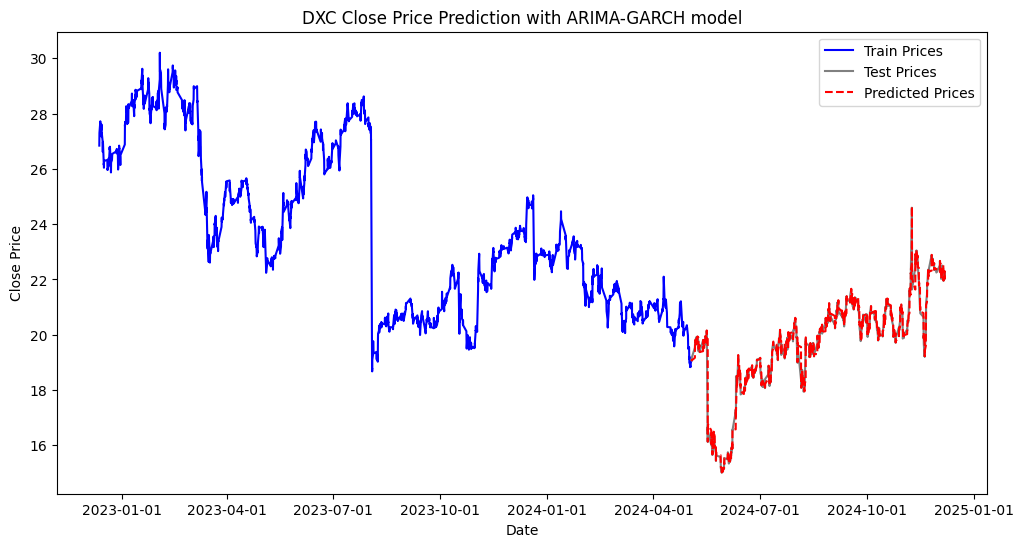

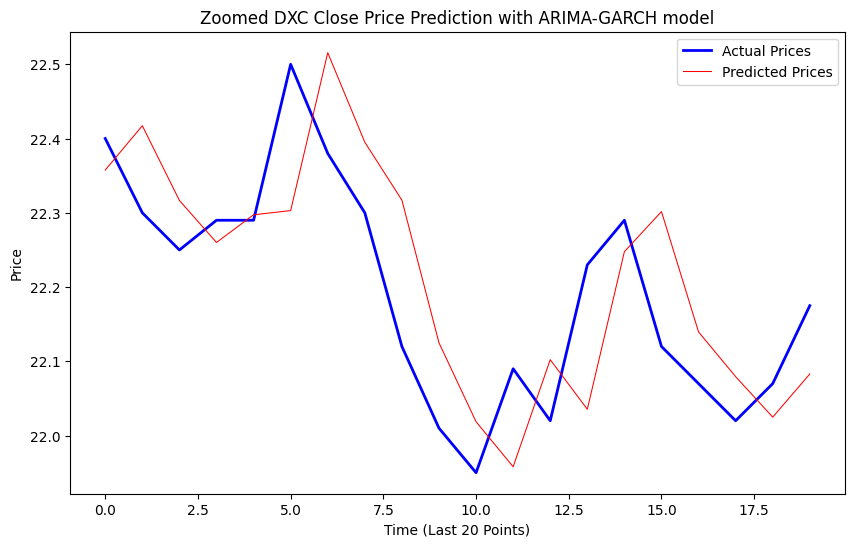

Mean Squared Error (MSE): 0.04615899621713657
Root Mean Squared Error (RMSE): 0.21
Mean Absolute Error (MAE): 0.12
Mean Absolute Percentage Error (MAPE): 0.61
Saving model to /content/drive/MyDrive/studia/Inżynierka/MAIN/trained_st/ARIMA-GARCH_DXC_arima-5_1_0_garch-1_1_mse-0.04616.ckpt
Model successfully saved to /content/drive/MyDrive/studia/Inżynierka/MAIN/trained_st/ARIMA-GARCH_DXC_arima-5_1_0_garch-1_1_mse-0.04616.ckpt


In [19]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare data
prices = data[['Datetime', 'Close']]
prices = prices.set_index('Datetime')
returns = data['Returns']


train_size = int(len(returns) * 0.7)
train_prices = prices[:train_size]
test_prices = prices[train_size:]
train_returns = returns[:train_size]
test_returns = returns[train_size:]

# ARIMA parameters
p, d, q = 5, 1, 0

# Initializing variables
history_prices = train_prices['Close'].tolist()
arima_predictions = []
garch_predictions = []

# Rolling forecast with ARIMA-GARCH
for t in range(len(test_prices)):
    # Step 1: Fit ARIMA on the historical prices
    arima_model = ARIMA(history_prices, order=(p, d, q))
    arima_fit = arima_model.fit()

    # Step 2: Use ARIMA to forecast the next value (mean forecast)
    arima_forecast = arima_fit.forecast()
    arima_predictions.append(arima_forecast[0])

    # Step 3: Calculate residuals from ARIMA model
    arima_residuals = arima_fit.resid

    # Step 4: Fit GARCH on ARIMA residuals
    garch_model = arch_model(arima_residuals, vol='GARCH', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    # Step 5: Forecast volatility (next residual)
    garch_forecast = garch_fit.forecast(horizon=1)
    predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, 0])
    predicted_residual = garch_forecast.mean.values[-1, 0]  # Mean residual forecast

    # Step 6: Combine ARIMA forecast and GARCH residual
    combined_forecast = arima_forecast[0] + predicted_residual
    garch_predictions.append(combined_forecast)

    # Step 7: Update history with the actual price
    history_prices.append(test_prices['Close'].iloc[t])

# Convert predictions to a pandas Series
combined_predictions = pd.Series(garch_predictions, index=test_prices.index)

# Plotting the training, test, and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(train_prices.index, train_prices['Close'], label='Train Prices', color="blue")
plt.plot(test_prices.index, test_prices['Close'], label='Test Prices', color="grey")
plt.plot(test_prices.index, combined_predictions, label='Predicted Prices', color='red', linestyle='--')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('DXC Close Price Prediction with ARIMA-GARCH model')
plt.legend()
plt.show()

# Zoom the Prediction
plt.figure(figsize=(10, 6))

# Plot last 20 data points of test prices and predictions
zoom_range = 20  # Number of data points to zoom into
plt.plot(np.arange(zoom_range), test_prices['Close'][-zoom_range:].values, 'b', label="Actual Prices", linewidth=2)
plt.plot(np.arange(zoom_range), combined_predictions[-zoom_range:].values, 'r', label="Predicted Prices", linewidth=0.75)

# Adding labels and title
plt.title("Zoomed DXC Close Price Prediction with ARIMA-GARCH model")
plt.xlabel('Time (Last 20 Points)')
plt.ylabel('Price')
plt.legend()
plt.show()

# Performance metrics
mse = mean_squared_error(test_prices['Close'], combined_predictions)
rmse = round(np.sqrt(mse), 2)
mae = round(mean_absolute_error(test_prices['Close'], combined_predictions), 2)
mape = round(np.mean(np.abs((test_prices['Close'] - combined_predictions) / test_prices['Close'])) * 100, 2)

# Output performance metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

data_directory = DATA_PATH
output = '/content/drive/MyDrive/studia/Inżynierka/MAIN/trained_st/'

filename = os.path.join(
            output,
            f'ARIMA-GARCH_{ticker}_arima-5_1_0_garch-1_1_mse-{mse:.5f}.ckpt')

print(f'Saving model to {filename}')

with open(filename, 'wb') as file:
    pickle.dump(garch_fit, file)
print(f"Model successfully saved to {filename}")
